# Summarise the previous results: clean and add the volume and dual computation functions, validate the results

In [1]:

from scipy.spatial import Delaunay
#import polyscope as ps

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._plotting import *

# Name the functions we are actually using:
#from barycentric._duals import compute_vd
# Example usage:

In [2]:
# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import compute_vd, triang_dual

# Plots
from ddgclib.ddgclib.barycentric import plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from ddgclib.ddgclib.barycentric import area_of_polygon, e_star, volume_of_geometric_object, plot_dual

# Area computations
from ddgclib.ddgclib.barycentric import d_area

# DDG gradient operations on primary edges (for continuum)
from ddgclib.ddgclib.barycentric import dP, dudt


In [3]:
points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]])
area = area_of_polygon(points)

In [4]:
import numpy as np
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Domain:
x_lb = 0
x_ub = R
y_lb = 0
y_ub = R

P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
#u_in = 1  # m⋅s−2, initial and inlet velocity   
u_in = 0.001  # m⋅s−2, initial and inlet velocity

# Physical parameters
mu = 8.90 * 1e-4  # Pa·s
h = R  # m, plate seperation
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)
G = (Q * 12 * mu) / (h**3)  # pressure gradient(?)
rho = 1000  # kg / m3
#G = dP/ L
Re = rho * Q * L / mu
# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A**2)

## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])
        
# velocity
def v_IC(HC, u_in):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_in, 0])

# mass 
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area(v)
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V
        
# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)
        
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalt to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components 
        
def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Solution
def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0
    

def BC_bool(x):
    #if (x[0] == 0) or (x[0] == 1) or (x[1] == 0) or (x[1] == 1):
    #if (x[0]  == x_lb) or (x[0] == x_ub) or (x[1] == y_lb) or (x[1] == y_ub):
    if (x[1] == y_lb) or (x[1] == y_ub):
        return True
    else:
        return False
    
def in_domain(x):
    if (x[0] >= x_lb) and (x[0] <= x_ub) and (x[1] >= y_lb) and (x[1] <= y_ub):
        return True
    else:
        return False
    
# Test case 
def incomp_poiseuille_2d(refinements=2, R=1, u_in=0.1):
    # Solid boundaries of plate
    x_lb = 0
    x_ub = R  # For simplicity
    y_lb = 0
    y_ub = R  # Actual parallel plate dimension
    domain = [(x_lb, x_ub), (y_lb, y_ub)]
    points = incom_Poi(domain, refinements=refinements)
    HC, tri = triang_dual(points)
    #HC.vertex_face_mesh(field_conversions=True)              
    HC = compute_vd(HC)            
    # Optionally plot
    #plot_dual_mesh_2D(HC, tri)

    # For each vertex compute its local dual area:
    Areas = []
    for vp1 in HC.V:
        area = 0 
        area += d_area(vp1)
        Areas.append(area)

    # Set ICs:
    mass_IC(HC)  # mass IC
    v_IC(HC, u_in)  # Velocity IC
    P_IC(HC)  # Pressure field IC
    return HC, tri


In [5]:
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points

# 2D

In [6]:
# Area computations
def d_volume(vp1, dim=2):
    """
    Compute the Barycentric dual volume (or area) 

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea

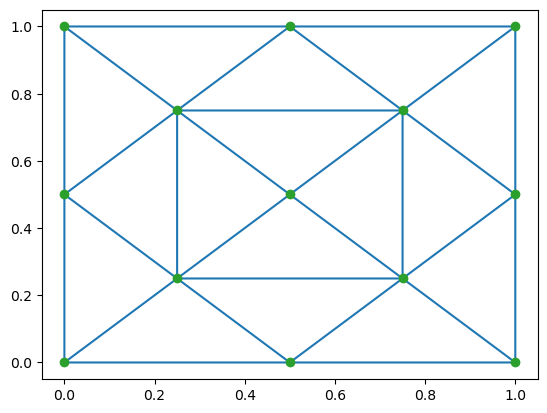

In [7]:
domain = [(0, 1),]*2
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
#HC = compute_vd(HC, cdist =1e-10)


In [8]:
plot_dual_mesh_2D(HC, tri, points)

AttributeError: 'Complex' object has no attribute 'Vd'

In [45]:
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)
dual_points = np.array(dual_points)

In [46]:
v_i =  HC.V[(0.5, 0.5)]
v_j =  HC.V[(0.75, 0.75)]

In [47]:
e_ij_star = 0  # Initialize total dual area to zero
# Find the shared dual vertices between vp1 and vp2
vdnn = v_i.vd.intersection(v_j.vd)  # Should always be 2 for dim=2

vd1 = list(vdnn)[0]
vd2 = list(vdnn)[1]
e_ij_star = np.linalg.norm(vd1.x_a - vd2.x_a) 
e_ij_star

0.23570226039551578912

# TODO: Compare the new integrators with the old using the case below:

In [48]:
# Pressure IC (new)
P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
mu = 8.90 * 1e-4  # Pa·s
A = 1  # m2
u_in = 0.0001  # m⋅s−2, initial and inlet velocity
u_in = 1e6# m⋅s−2, initial and inlet velocity
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)

#Q = 1

def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """

    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP

def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])

        print(f'P_ic({v.x_a[0]}) = {P_ic(v.x_a[0])}')
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)
        
P_IC(HC)
v_IC(HC, u_in)
mass_IC(HC)
v_i =  HC.V[(0.5, 0.5)]

P_ic(1.0) = 78956.86030644068
P_ic(0.75) = 84548.89522983051
P_ic(1.0) = 78956.86030644068
P_ic(0.5) = 90140.93015322034
P_ic(0.75) = 84548.89522983051
P_ic(1.0) = 78956.86030644068
P_ic(0.5) = 90140.93015322034
P_ic(0.25) = 95732.96507661017
P_ic(0.0) = 101325.0
P_ic(0.0) = 101325.0
P_ic(0.25) = 95732.96507661017
P_ic(0.0) = 101325.0
P_ic(0.5) = 90140.93015322034


In [49]:
dP(v_i, dim=2)

-
vp2.x, vp1.x = ((0.25, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551587
-
vp2.x, vp1.x = ((0.25, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
dP_i = [4.42201831e-13 4.42201831e-13]


array([4.42201831e-13, 4.42201831e-13], dtype=float128)

In [50]:
dudt(v_i, dim=2)

-
vp2.x, vp1.x = ((0.25, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551587
-
vp2.x, vp1.x = ((0.25, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
dP_i = [4.42201831e-13 4.42201831e-13]
du_i = [0. 0.]


array([-4.7462081e-15, -4.7462081e-15], dtype=float128)

In [51]:
v_i =  HC.V[(0.75, 0.75)]
dP(v_i, dim=2)

-
vp2.x, vp1.x = ((0.5, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.75, 0.25), (0.75, 0.75))
vp2.P - vp1.P = [0. 0.]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.25, 0.75), (0.75, 0.75))
vp2.P - vp1.P = [11184.06984678 11184.06984678]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.2635231383473649
-
vp2.x, vp1.x = ((0.5, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.2635231383473649
dP_i = [1864.01164113 1864.01164113]


array([1864.01164113, 1864.01164113], dtype=float128)

In [52]:
dudt(v_i, dim=2)

-
vp2.x, vp1.x = ((0.5, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.75, 0.25), (0.75, 0.75))
vp2.P - vp1.P = [0. 0.]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.25, 0.75), (0.75, 0.75))
vp2.P - vp1.P = [11184.06984678 11184.06984678]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.2635231383473649
-
vp2.x, vp1.x = ((0.5, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.2635231383473649
dP_i = [1864.01164113 1864.01164113]
du_i = [0. 0.]


array([-13.8242706, -13.8242706], dtype=float128)

# 3 D


In [53]:
domain = [(0, 2),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


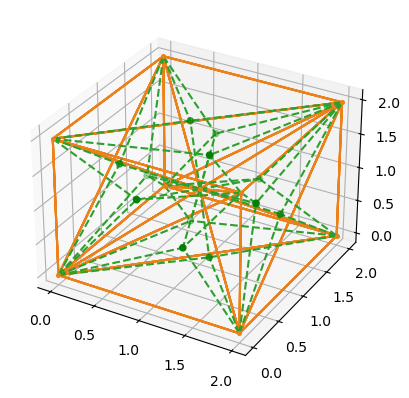

In [54]:
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)

In [55]:
for vd in HC.V:
    print(vd.x)

(0, 0, 0)
(2, 2, 2)
(2, 0, 0)
(0, 2, 0)
(2, 2, 0)
(0, 0, 2)
(2, 0, 2)
(0, 2, 2)
(1.0, 1.0, 1.0)


In [56]:
vi = HC.V[(1.0, 1.0, 1.0)]
vj = HC.V[(2, 2, 2)]

In [57]:
vdnn = vi.vd.intersection(vj.vd)
vdnn


{<barycentric._vertex.VertexScalarField at 0x7b2e591e89d0>,
 <barycentric._vertex.VertexScalarField at 0x7b2e61bec250>}

In [58]:
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points)    
local_dual_points

array([[0.75, 1.25, 1.75],
       [1.75, 0.75, 1.25],
       [1.25, 1.75, 0.75],
       [1.75, 1.25, 0.75],
       [0.75, 1.75, 1.25],
       [1.25, 0.75, 1.75]])

In [59]:
area_of_polygon(local_dual_points)

1.7320508075688772

In [60]:
e_ij_star = 0  # Initialize total dual area to zero
vdnn = vi.vd.intersection(vj.vd)
 
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points) 
e_ij_star = area_of_polygon(local_dual_points)
e_ij_star

1.7320508075688772

# Extra test

In [61]:
domain = [(0, 0.5),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


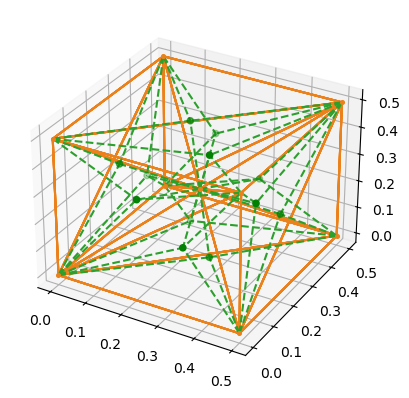

In [62]:
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)

In [63]:
vi = HC.V[(0.25, 0.25, 0.25)]

In [64]:
for vj in vi.nn:
    e_ij_star = 0  # Initialize total dual area to zero
    vdnn = vi.vd.intersection(vj.vd)
    print(len(list(vdnn)))
    local_dual_points = []
    for vd in vdnn:
        local_dual_points.append(vd.x)

    local_dual_points = np.array(local_dual_points) 
    e_ij_star = area_of_polygon(local_dual_points)
    print(e_ij_star)

4
0.038273277230987154
6
0.09472152853892296
4
0.038273277230987154
4
0.038273277230987154
4
0.038273277230987154
6
0.12178482240718669
4
0.038273277230987154
4
0.038273277230987154


## Test if the sum of unit cube dual volumes is 1 m$^3$ as expected

/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


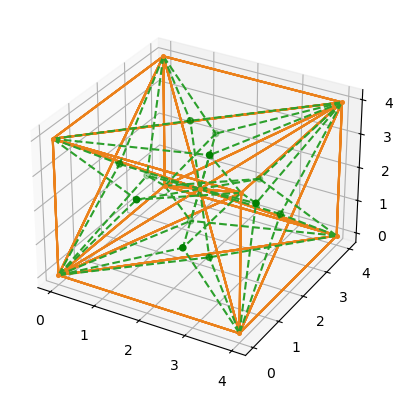

In [65]:
domain = [(0, 4.0),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
for i in range(0):
    HC.refine_all_star()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
#dual_points

In [66]:
v = HC.V[(2, 2, 2)]
points = []
faces = []
# Loop over primary edges
for v2 in v.nn:
    # For each primary edge:
    # find local dual points intersecting vertices terminating edge:
    dset = v2.vd.intersection(v.vd)
    pi = []
    for vd in dset:
        #pi.append(vd.x + 1e-9 * np.random.rand())
        pi.append(vd.x)
        points.append(vd.x)
    
    pi = np.array(pi)
    pi_2d = pi[:, :2] + 1e-9 * np.random.rand()
    # find the (delaunay) simplices from scipy:
    tri = scipy.spatial.Delaunay(pi_2d, qhull_options='QJ')
    faces.append(tri.simplices)
    
pi, tri.simplices

(array([[2.5, 1.5, 0.5],
        [2.5, 3.5, 1.5],
        [1.5, 2.5, 0.5],
        [3.5, 2.5, 1.5]]),
 array([[0, 1, 2],
        [1, 0, 3]], dtype=int32))

In [67]:
np.random.rand()

0.7638148353876637

In [68]:
dset = v2.vd.intersection(v.vd)
dset

{<barycentric._vertex.VertexScalarField at 0x7b2e59180b10>,
 <barycentric._vertex.VertexScalarField at 0x7b2e61bb3050>}

In [69]:
import polyscope as ps


plot_dual(v, HC)
ps.show()

In [70]:
# NEW volume function
def v_star(v_i):
    """
    Compute the discrete (Hodge) dual volume of a vertex v 
    :param v: vertex object
    :return: V_d, scalar dual volume 
    """
    for v_j in v_i.nn:
        print('-')
        print(f'v_j = {v_j.x}')
        # Compute the dual area of the primary edge e_ij:
        base_area = e_star(v_i, v_j, dim=3)
        print(f'base_area = {base_area}')
        # Calculate the primary edge length
        l_ij = np.linalg.norm(v_j.x_a - v_i.x_a)
        print(f'l_ij  = {l_ij }')
        # Calculate the volume of the geometric object.
        V_d = 1/3 * base_area * l_ij
        
    return V_d

In [71]:
V = 0
for v_i in HC.V:
    print('=')
    print(f'v_i = {v_i.x}')
    V_d = v_star(v_i)
    print(f'V_d = {V_d}')
    V += V_d
    
print(f'V = {V_d}')

=
v_i = (0, 0, 0)
-
v_j = (0, 0, 4.0)
local_dual_points = [(1.5, 0.5, 2.5), (0.5, 1.5, 2.5), (0.5, 1.5, 2.5)]
base_area = 0.0
l_ij  = 4.0
-
v_j = (4.0, 0, 4.0)
local_dual_points = [(1.5, 0.5, 2.5), (2.5, 0.5, 1.5), (2.5, 0.5, 1.5)]
base_area = 0.0
l_ij  = 5.656854249492381
-
v_j = (2.0, 2.0, 2.0)
local_dual_points = [(0.5, 1.5, 2.5), (0.5, 2.5, 1.5), (2.5, 1.5, 0.5), (1.5, 0.5, 2.5), (1.5, 2.5, 0.5), (2.5, 0.5, 1.5), (2.5, 0.5, 1.5)]
base_area = 7.794228634059946
l_ij  = 3.4641016151377544
-
v_j = (0, 4.0, 4.0)
local_dual_points = [(0.5, 2.5, 1.5), (0.5, 1.5, 2.5), (0.5, 1.5, 2.5)]
base_area = 0.0
l_ij  = 5.656854249492381
-
v_j = (0, 4.0, 0)
local_dual_points = [(0.5, 2.5, 1.5), (1.5, 2.5, 0.5), (1.5, 2.5, 0.5)]
base_area = 0.0
l_ij  = 4.0
-
v_j = (4.0, 0, 0)
local_dual_points = [(2.5, 1.5, 0.5), (2.5, 0.5, 1.5), (2.5, 0.5, 1.5)]
base_area = 0.0
l_ij  = 4.0
-
v_j = (4.0, 4.0, 0)
local_dual_points = [(2.5, 1.5, 0.5), (1.5, 2.5, 0.5), (1.5, 2.5, 0.5)]
base_area = 0.0
l_ij  = 5.656854249

# Future unittests
## Area tests 

In [72]:

#from area_of_polygon import area_of_polygon

def test_area_of_square():
  """Tests the area of a square."""

  square_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
  expected_area = 1

  calculated_area = area_of_polygon(square_points)

  assert calculated_area == expected_area

def test_area_of_triangle():
  """Tests the area of a triangle."""

  triangle_points = np.array([[0, 0], [1, 0], [0.5, 1]])
  expected_area = 0.5

  calculated_area = area_of_polygon(triangle_points)

  assert calculated_area == expected_area

def test_area_of_polygon_with_holes():
  """Tests the area of a polygon with holes."""

  polygon_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
  hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
  expected_area = 1 - 0.25

  calculated_area = area_of_polygon(polygon_points, [hole_points])

  assert calculated_area == expected_area

test_area_of_triangle()
test_area_of_square()
test_area_of_polygon_with_holes()

AxisError: axis 1 is out of bounds for array of dimension 1

## Volumes
### Test pyramid

In [ ]:
import numpy as np
#from volume_of_geometric_object import volume_of_geometric_object

# Create a pyramid with a known volume.
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])
pyramid_volume = 166.67

# Calculate the volume of the pyramid using your code.
pyramid_volume_calculated = volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

# Compare the calculated volume to the known volume.
pyramid_volume_calculated

In [ ]:
.30.1